In [59]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [60]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [61]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [62]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)

cad_jpy_df['Returns'] = (cad_jpy_df[["Price"]].pct_change() * 100)

# In this case, you may have to replace inf, -inf values with np.nan"s

returns = cad_jpy_df.replace(-np.inf, np.nan)

# Drop 
returns.dropna()
returns.tail()

,Price,Open,High,Low,Returns
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [63]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged_Returns'] = cad_jpy_df["Returns"].shift()
#drop NAs for dataframe
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.tail()

,Price,Open,High,Low,Returns,Lagged_Returns
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


### Train Test Split

In [64]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [65]:
# Create four dataframes:
# X_train (training set using just the independent variables), dataframe
X_train = train["Lagged_Returns"].to_frame()

# X_test (test set of of just the independent variables), dataframe
X_test = test["Lagged_Returns"].to_frame()

# Y_train (training set using just the "y" variable, i.e., "Futures Return"), dataframe
y_train = train["Returns"]

# Y_test (test set of just the "y" variable), dataframe
y_test = test["Returns"]

In [66]:
# Preview the X_train data
X_train.head()

,Lagged_Returns
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901


# Linear Regression Model

In [67]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
reg_model = LinearRegression().fit(X_train, y_train)

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [68]:
# Make a prediction of "y" values using just the test dataset
y_prediction = reg_model.predict(X_test)

In [69]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
y_df = y_test.to_frame()
y_df["predicted return"] = y_prediction

,Returns,predicted return
Date,,
2018-01-01,0.245591,0.005434
2018-01-02,-0.055679,-0.007317
2018-01-03,0.011142,0.000340
2018-01-04,0.601604,-0.001358
2018-01-05,0.919158,-0.016366
...,...,...
2020-05-29,0.076697,0.001846
2020-06-01,1.251756,-0.003024
2020-06-02,1.425508,-0.032890


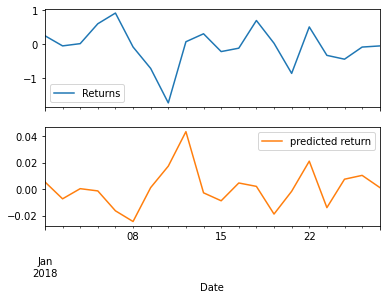

In [70]:
# Plot the first 20 predictions vs the true values
y_df[:20].plot(subplots=True)
y_df

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [71]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
y_mse = mean_squared_error(y_df["Returns"], y_df["predicted return"])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
y_rmse = np.sqrt(y_mse)

#print out the rmse result
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {y_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445805658569028


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [72]:
# Construct a dataframe using just the "y" training data:
y_train_df = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
y_train_df["in-sample predictions"] = reg_model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(y_train_df["Returns"],y_train_df["in-sample predictions"])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)

print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.841994632894117


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** The model performs better on out of sample data than the in sample data. As we can see the RMSE of out of sample is 0.6445 which is lower than the rmse of 0.8418 from in sample data.